In [64]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import geopandas as gpd
from datetime import datetime, timedelta
import ee
import urllib.request
import rasterio
from rasterio.mask import mask
import xarray as xr

In [18]:
# Initialize EE
ee.Initialize()

In [19]:
# Read shapefile with geopandas

GDF_01 = gpd.read_file(r"GIS/ROI.shp")

GDF_01

,geometry
0,"POLYGON ((-59.61517 -35.45838, -59.61456 -35.4..."


In [20]:
# For now, we'll work with ROI´s bounding box
BB_01 = GDF_01.total_bounds

BB_01

array([-60.2186    , -35.912586  , -59.181292  , -35.45137998])

In [21]:
# Define coordinates
x_min, y_min, x_max, y_max = BB_01

# Create ee.Geometry
ROI = ee.Geometry.Rectangle([x_min, y_min, x_max, y_max])

ROI

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -60.21859999999998,
              -35.451379979999956
            ],
            [
              -60.21859999999998,
              -35.912585999999976
            ],
            [
              -59.181291999999985,
              -35.912585999999976
            ],
            [
              -59.181291999999985,
              -35.451379979999956
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [22]:
# Define years of interest
Ys = [2019, 2020, 2021, 2022, 2023]

# Define a dictionary of image collections
DICT_Cs_01 = {}

for Y in Ys:

    DICT_Cs_01[f"{Y}"] = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                .filterBounds(ROI)\
                .filterDate(f"{Y}-01-01", f"{Y+1}-01-01")\
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 25))
DICT_Cs_01

{'2019': <ee.imagecollection.ImageCollection at 0x19bd8c04850>,
 '2020': <ee.imagecollection.ImageCollection at 0x19bd8c05010>,
 '2021': <ee.imagecollection.ImageCollection at 0x19bd8c05750>,
 '2022': <ee.imagecollection.ImageCollection at 0x19bd8c05e90>,
 '2023': <ee.imagecollection.ImageCollection at 0x19bd8c06550>}

In [23]:
# Get a glimpse on the number of images for each year

for k, C in DICT_Cs_01.items():

    print(k, C.size().getInfo())

2019 167
2020 202
2021 192
2022 172
2023 183


In [24]:
# Calculate NDVI on every image

# Create a function to calculate NDVI
def s2_ndvi(image):
    
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    
    return image.addBands(ndvi)

# Map the function over the ICs
for k, C in DICT_Cs_01.items():
    
    DICT_Cs_01[f"{k}"] = C.map(s2_ndvi)

DICT_Cs_01

{'2019': <ee.imagecollection.ImageCollection at 0x19bd8d74e50>,
 '2020': <ee.imagecollection.ImageCollection at 0x19bdb0c4d90>,
 '2021': <ee.imagecollection.ImageCollection at 0x19bdb0c7990>,
 '2022': <ee.imagecollection.ImageCollection at 0x19bd8cbe1d0>,
 '2023': <ee.imagecollection.ImageCollection at 0x19bd8db9dd0>}

In [25]:
# Check bands

"NDVI" in DICT_Cs_01["2019"].first().bandNames().getInfo()

True

In [26]:
# For each year create an image that takes the median NDVI

# Dicitonary of images
DICT_Is_01 = {}

for k, C in DICT_Cs_01.items():
    
    DICT_Is_01[f"{k}"] = C.select('NDVI').median()

DICT_Is_01

{'2019': <ee.image.Image at 0x19bd8d97d50>,
 '2020': <ee.image.Image at 0x19bdc41ce50>,
 '2021': <ee.image.Image at 0x19bdc41c710>,
 '2022': <ee.image.Image at 0x19bdc41d050>,
 '2023': <ee.image.Image at 0x19bdc41c410>}

In [27]:
# Get spatial resolution
OS_01 = DICT_Cs_01["2019"].select("B4").first().projection().nominalScale().getInfo()

print(f"Original scale: {OS_01:.1f} m")

Original scale: 10.0 m


In [28]:
# # Download images locally

# for k, I in DICT_Is_01.items():

#   FN = f"S2-MED-NDVI-{k}.tif"

#   # Define the export parameters.
#   url = I.getDownloadURL({
#   "scale" : 500,
#   "crs" : "EPSG:4326",
#   "region" : ROI,
#   "filePerBand": False,
#   "format" : "GEO_TIFF"
#   })

#   # Start downloading
#   urllib.request.urlretrieve(url, fr"Output/{FN}")
#   print(f"{FN} downloaded!")

In [29]:
# Read images with rasterio
DICT_Rs_01 = {}

for Y in Ys:

    FN = f"S2-MED-NDVI-{Y}.tif"

    DICT_Rs_01[f"{Y}"] = rasterio.open(fr"Output/{FN}")

DICT_Rs_01

{'2019': <open DatasetReader name='Output/S2-MED-NDVI-2019.tif' mode='r'>,
 '2020': <open DatasetReader name='Output/S2-MED-NDVI-2020.tif' mode='r'>,
 '2021': <open DatasetReader name='Output/S2-MED-NDVI-2021.tif' mode='r'>,
 '2022': <open DatasetReader name='Output/S2-MED-NDVI-2022.tif' mode='r'>,
 '2023': <open DatasetReader name='Output/S2-MED-NDVI-2023.tif' mode='r'>}

In [30]:
# Create NDVI palette

ndvi_palette_hex = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000',
               '529400', '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301'] 

ndvi_palette_rgba  = [colors.hex2color('#' + hex_color) for hex_color in ndvi_palette_hex]

ndvi_palette = ListedColormap(ndvi_palette_rgba)

In [31]:
# Figure parameters

# Width, height
W, H = 4, 2.5

# Aspect ratio
AR = W/H

# Set figure bounds
Bs = DICT_Rs_01["2019"].bounds

# Set fontsizes
T_FS = 14
AX_FS = 12

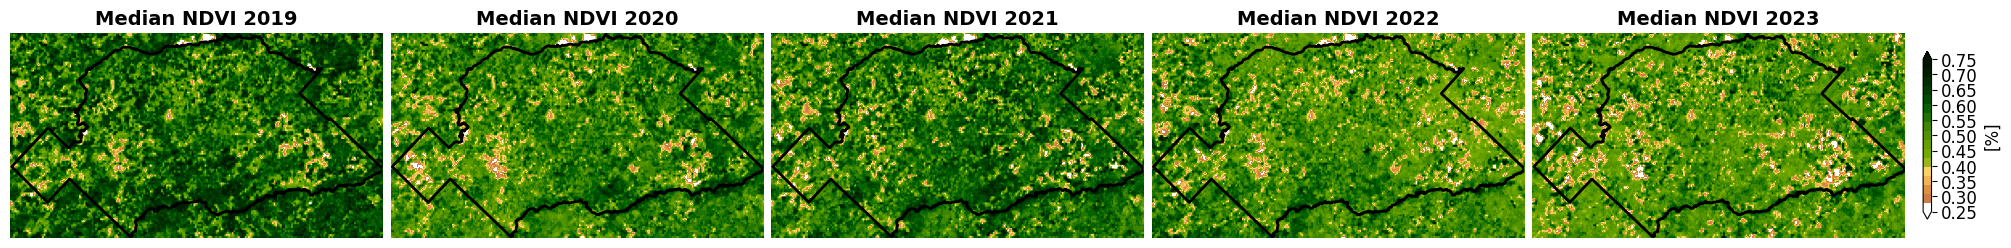

In [32]:
fig, axs = plt.subplots(1, 5, figsize=(5*W, H), constrained_layout=True)

for (k, R), ax in zip(DICT_Rs_01.items(), axs.ravel()):

    _ = ax.imshow(R.read(1), vmin=0.25, vmax=0.75, cmap=ndvi_palette, aspect=1/AR, extent=(Bs.left, Bs.right, Bs.bottom, Bs.top))

    ax.set_title(f"Median NDVI {k}", fontweight="bold", fontsize=T_FS)

    GDF_01.plot(ax=ax, facecolor="none", edgecolor="black", zorder=2, linewidth=2, alpha=1)
    
    ax.axis("off")

CB = plt.colorbar(_, extend="both", ticks=np.arange(0.25, .80, .05), shrink=.75)

CB.ax.tick_params(labelsize=AX_FS)

CB.set_label("[%]", fontsize=AX_FS)

# plt.savefig(r"Output/_01.png")
plt.show();

In [33]:
# CHIRPS

In [34]:
# Define a dictionary of image collections
DICT_Cs_02 = {}

for Y in Ys:

    DICT_Cs_02[f"{Y}"] = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")\
                .filterBounds(ROI)\
                .filterDate(f"{Y}-01-01", f"{Y+1}-01-01")

DICT_Cs_02

{'2019': <ee.imagecollection.ImageCollection at 0x19bdb06c610>,
 '2020': <ee.imagecollection.ImageCollection at 0x19bdc30ff10>,
 '2021': <ee.imagecollection.ImageCollection at 0x19bdc783950>,
 '2022': <ee.imagecollection.ImageCollection at 0x19bd8d8a990>,
 '2023': <ee.imagecollection.ImageCollection at 0x19bdc74da90>}

In [35]:
# Define new dictionary of images with the cumulative sum for each year
DICT_Is_02 = {}

for k, C in DICT_Cs_02.items():

    DICT_Is_02[k] = C.sum()

DICT_Is_02

{'2019': <ee.image.Image at 0x19bdc765810>,
 '2020': <ee.image.Image at 0x19bdc764d10>,
 '2021': <ee.image.Image at 0x19bdc7b6390>,
 '2022': <ee.image.Image at 0x19bdc7b6f10>,
 '2023': <ee.image.Image at 0x19bdc6d9590>}

In [36]:
# Get spatial resolution
OS_02 = DICT_Cs_02["2019"].select("precipitation").first().projection().nominalScale().getInfo()

print(f"Original scale: {OS_02:.1f} m")

Original scale: 5566.0 m


In [37]:
# # Download images locally

# for k, I in DICT_Is_02.items():

#   FN = f"CHIRPS-AC-PPT-{k}.tif"

#   # Define the export parameters.
#   url = I.getDownloadURL({
#   "scale" : OS_02,
#   "crs" : "EPSG:4326",
#   "region" : ROI,
#   "filePerBand": False,
#   "format" : "GEO_TIFF"
#   })

#   # Start downloading
#   urllib.request.urlretrieve(url, fr"Output/{FN}")
#   print(f"{FN} downloaded!")

In [38]:
# Read images with rasterio
DICT_Rs_02 = {}

for Y in Ys:

    FN = f"CHIRPS-AC-PPT-{Y}.tif" 

    DICT_Rs_02[f"{Y}"] = rasterio.open(fr"Output/{FN}")

DICT_Rs_02

{'2019': <open DatasetReader name='Output/CHIRPS-AC-PPT-2019.tif' mode='r'>,
 '2020': <open DatasetReader name='Output/CHIRPS-AC-PPT-2020.tif' mode='r'>,
 '2021': <open DatasetReader name='Output/CHIRPS-AC-PPT-2021.tif' mode='r'>,
 '2022': <open DatasetReader name='Output/CHIRPS-AC-PPT-2022.tif' mode='r'>,
 '2023': <open DatasetReader name='Output/CHIRPS-AC-PPT-2023.tif' mode='r'>}

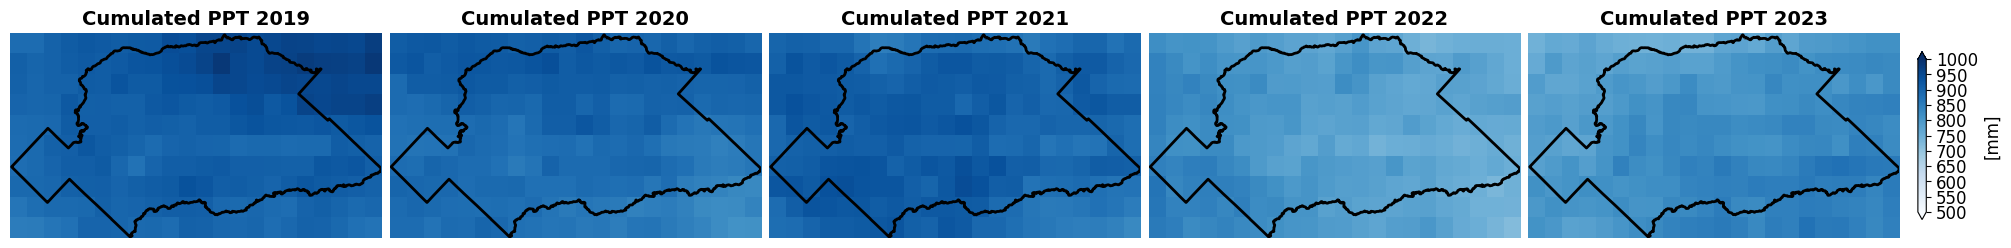

In [39]:
fig, axs = plt.subplots(1, 5, figsize=(5*W, H), constrained_layout=True)

for (k, R), ax in zip(DICT_Rs_02.items(), axs.ravel()):

    _ = ax.imshow(R.read(1), vmin=500, vmax=1000, cmap="Blues", aspect=1/AR, extent=(Bs.left, Bs.right, Bs.bottom, Bs.top))

    ax.set_title(f"Cumulated PPT {k}", fontweight="bold", fontsize=T_FS)

    GDF_01.plot(ax=ax, facecolor="none", edgecolor="black", zorder=2, linewidth=2, alpha=1)
    
    ax.axis("off")

CB = plt.colorbar(_, extend="both", ticks=np.arange(500, 1050, 50), shrink=.75)

CB.ax.tick_params(labelsize=AX_FS)

CB.set_label("[mm]", fontsize=AX_FS)

# plt.savefig(r"Output/_02.png")
plt.show();

In [40]:
# ETR : MODIS (Gap filled version as MOD16A2 doesn't have data prior to 2021)

In [41]:
# Define a dictionary of image collections
DICT_Cs_03 = {}

for Y in Ys:

    DICT_Cs_03[f"{Y}"] = ee.ImageCollection("MODIS/061/MOD16A2GF")\
                .filterBounds(ROI)\
                .filterDate(f"{Y}-01-01", f"{Y+1}-01-01")\
                .map(lambda i: i.select('ET').multiply(0.1))

DICT_Cs_03

{'2019': <ee.imagecollection.ImageCollection at 0x19bdc41f9d0>,
 '2020': <ee.imagecollection.ImageCollection at 0x19bdc426110>,
 '2021': <ee.imagecollection.ImageCollection at 0x19bd87a5d10>,
 '2022': <ee.imagecollection.ImageCollection at 0x19bdc765250>,
 '2023': <ee.imagecollection.ImageCollection at 0x19bdce2c910>}

In [42]:
for Y in Ys:
    
    print(Y, DICT_Cs_03[f"{Y}"].size().getInfo())

2019 46
2020 46
2021 46
2022 46
2023 46


In [43]:
# Check bands
DICT_Cs_03["2019"].first().bandNames().getInfo()

['ET']

In [44]:
# For each year create an image that takes the sum of ET

# Dictionary of images
DICT_Is_03 = {}

for k, C in DICT_Cs_03.items():
    
    DICT_Is_03[f"{k}"] = C.select('ET').sum()

DICT_Is_03

{'2019': <ee.image.Image at 0x19bdce51c10>,
 '2020': <ee.image.Image at 0x19bdce51690>,
 '2021': <ee.image.Image at 0x19bdce45c90>,
 '2022': <ee.image.Image at 0x19bdce45e50>,
 '2023': <ee.image.Image at 0x19bdce443d0>}

In [45]:
# Get spatial resolution
OS_03 = DICT_Cs_03["2019"].select("ET").first().projection().nominalScale().getInfo()

print(f"Original scale: {OS_03:.1f} m")

Original scale: 463.3 m


In [46]:
# # Download images locally

# for k, I in DICT_Is_03.items():

#   FN = f"MODIS-ETR-{k}.tif"

#   # Define the export parameters.
#   url = I.getDownloadURL({
#   "scale" : OS_03,
#   "crs" : "EPSG:4326",
#   "region" : ROI,
#   "filePerBand": False,
#   "format" : "GEO_TIFF"
#   })

#   # Start downloading
#   urllib.request.urlretrieve(url, fr"Output/{FN}")
#   print(f"{FN} downloaded!")

In [47]:
# Read images with rasterio
DICT_Rs_03 = {}

for Y in Ys:

    FN = f"MODIS-ETR-{Y}.tif"

    DICT_Rs_03[f"{Y}"] = rasterio.open(fr"Output/{FN}")

DICT_Rs_03

{'2019': <open DatasetReader name='Output/MODIS-ETR-2019.tif' mode='r'>,
 '2020': <open DatasetReader name='Output/MODIS-ETR-2020.tif' mode='r'>,
 '2021': <open DatasetReader name='Output/MODIS-ETR-2021.tif' mode='r'>,
 '2022': <open DatasetReader name='Output/MODIS-ETR-2022.tif' mode='r'>,
 '2023': <open DatasetReader name='Output/MODIS-ETR-2023.tif' mode='r'>}

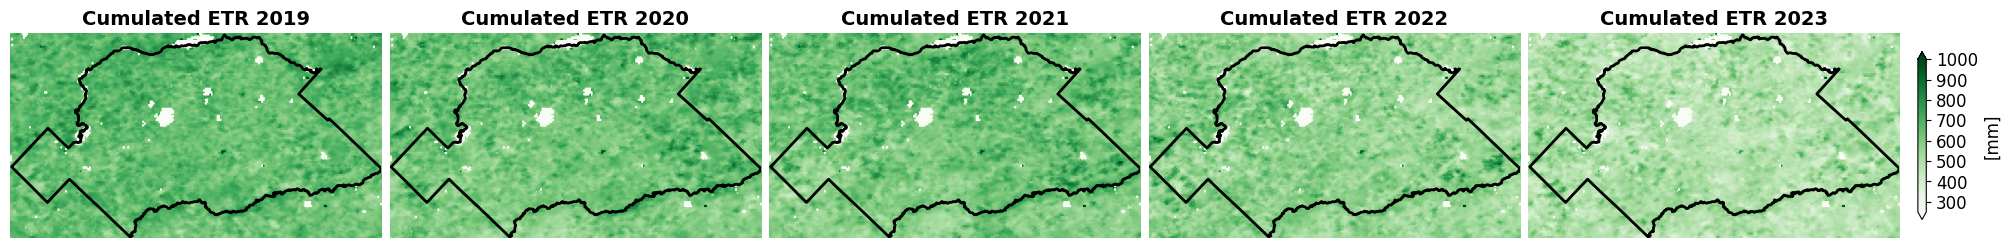

In [48]:
fig, axs = plt.subplots(1, 5, figsize=(5*W, H), constrained_layout=True)

for (k, R), ax in zip(DICT_Rs_03.items(), axs.ravel()):

    _ = ax.imshow(R.read(1), vmin=250, vmax=1000, cmap="Greens", aspect=1/AR, extent=(Bs.left, Bs.right, Bs.bottom, Bs.top))

    ax.set_title(f"Cumulated ETR {k}", fontweight="bold", fontsize=T_FS)

    GDF_01.plot(ax=ax, facecolor="none", edgecolor="black", zorder=2, linewidth=2, alpha=1)
    
    ax.axis("off")

CB = plt.colorbar(_, extend="both", ticks=np.arange(200, 1100, 100), shrink=.75)

CB.ax.tick_params(labelsize=AX_FS)

CB.set_label("[mm]", fontsize=AX_FS)

# plt.savefig(r"Output/_03.png")
plt.show();

In [49]:
# Plot them all together into 3 columns and 3 rows

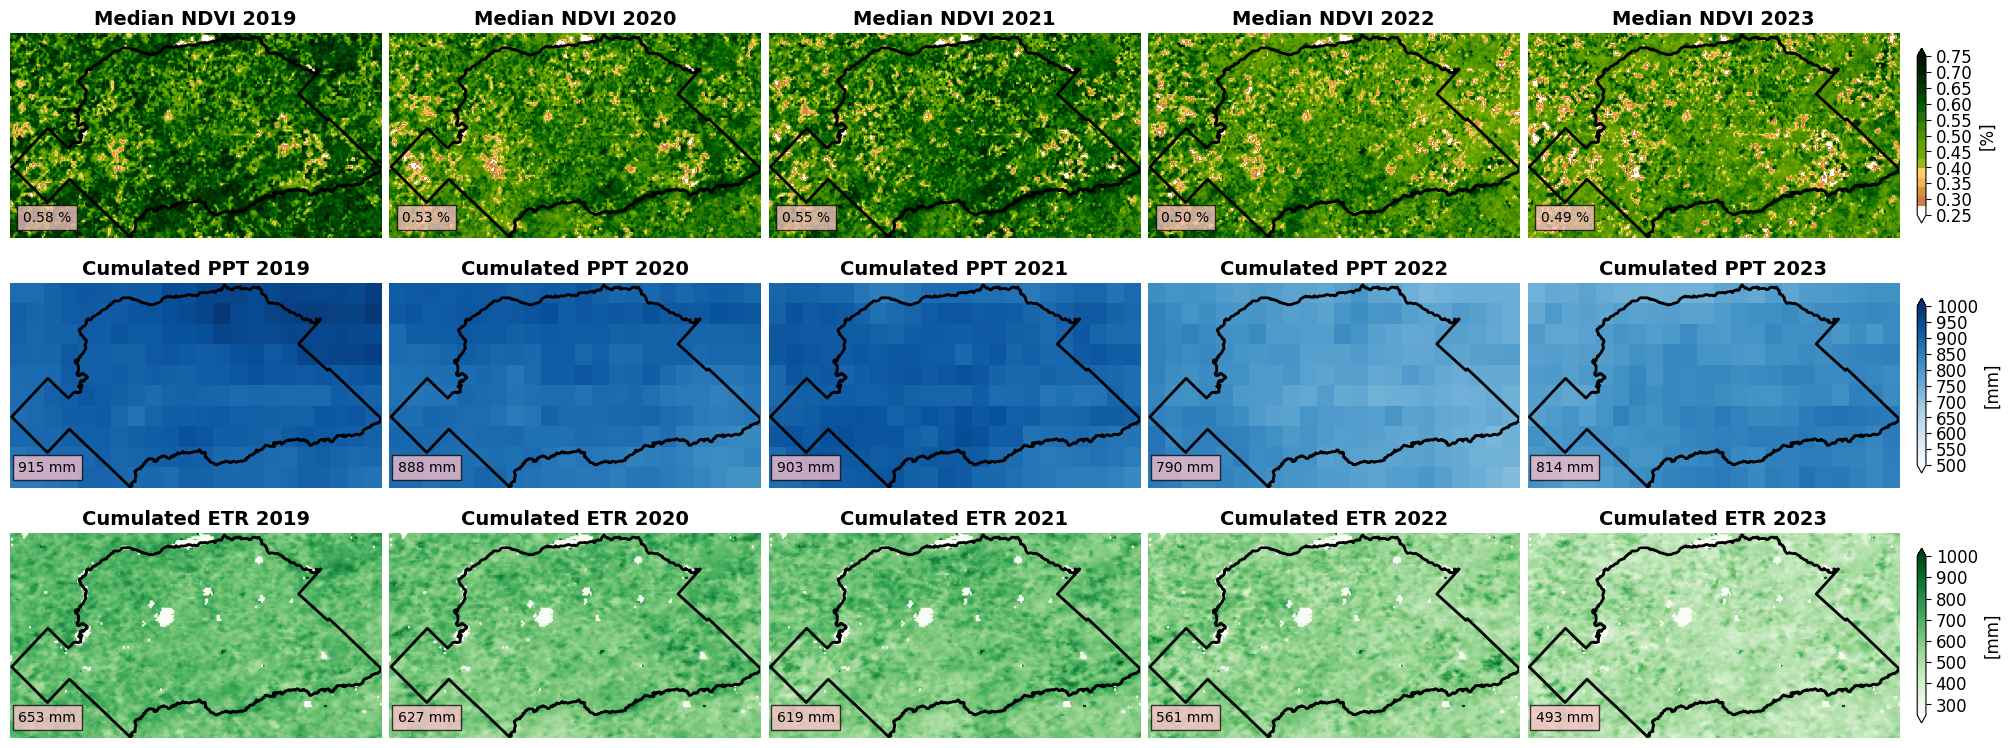

In [50]:
fig, axs = plt.subplots(3, 5, figsize=(5*W, 3*H), constrained_layout=True)

for (k, R), ax in zip(DICT_Rs_01.items(), axs.ravel()[:5]):

    _ = ax.imshow(R.read(1), vmin=0.25, vmax=0.75, cmap=ndvi_palette, aspect=1/AR, extent=(Bs.left, Bs.right, Bs.bottom, Bs.top))

    ax.set_title(f"Median NDVI {k}", fontweight="bold", fontsize=T_FS)

    GDF_01.plot(ax=ax, facecolor="none", edgecolor="black", zorder=2, linewidth=2, alpha=1)

    ax.axis("off")

    # Annotate with mean value
    ax.text(0.1, 0.1, f"{R.read(1).mean():.2f} %", transform=ax.transAxes, ha="center", va="center", color="black", fontsize=10, bbox=dict(facecolor='pink', alpha=0.75))


CB = plt.colorbar(_, extend="both", ticks=np.arange(0.25, .80, .05), shrink=.75)

CB.ax.tick_params(labelsize=AX_FS)

CB.set_label("[%]", fontsize=AX_FS)

for (k, R), ax in zip(DICT_Rs_02.items(), axs.ravel()[5:10]):

    _ = ax.imshow(R.read(1), vmin=500, vmax=1000, cmap="Blues", aspect=1/AR, extent=(Bs.left, Bs.right, Bs.bottom, Bs.top))

    ax.set_title(f"Cumulated PPT {k}", fontweight="bold", fontsize=T_FS)

    GDF_01.plot(ax=ax, facecolor="none", edgecolor="black", zorder=2, linewidth=2, alpha=1)
    
    ax.axis("off")

    # Annotate with mean value
    ax.text(0.1, 0.1, f"{R.read(1).mean():.0f} mm", transform=ax.transAxes, ha="center", va="center", color="black", fontsize=10, bbox=dict(facecolor='pink', alpha=0.75))


CB = plt.colorbar(_, extend="both", ticks=np.arange(500, 1050, 50), shrink=.75)

CB.ax.tick_params(labelsize=AX_FS)

CB.set_label("[mm]", fontsize=AX_FS)

for (k, R), ax in zip(DICT_Rs_03.items(), axs.ravel()[10:15]):

    _ = ax.imshow(R.read(1), vmin=250, vmax=1000, cmap="Greens", aspect=1/AR, extent=(Bs.left, Bs.right, Bs.bottom, Bs.top))

    ax.set_title(f"Cumulated ETR {k}", fontweight="bold", fontsize=T_FS)

    GDF_01.plot(ax=ax, facecolor="none", edgecolor="black", zorder=2, linewidth=2, alpha=1)
    
    ax.axis("off")
    
    # Annotate with mean value
    ax.text(0.1, 0.1, f"{R.read(1).mean():.0f} mm", transform=ax.transAxes, ha="center", va="center", color="black", fontsize=10, bbox=dict(facecolor='pink', alpha=0.75))


CB = plt.colorbar(_, extend="both", ticks=np.arange(200, 1100, 100), shrink=.75)

CB.ax.tick_params(labelsize=AX_FS)

CB.set_label("[mm]", fontsize=AX_FS)

# plt.savefig(r"Output/_04.png")
plt.show();

In [51]:
# Create a DF with mean values over ROI

DF_01 = pd.DataFrame()

DF_01["Y"] = Ys

NDVIs = []
for k, R in DICT_Rs_01.items():

    NDVIs.append(R.read(1).mean())

DF_01["NDVI"] = NDVIs

PPTs = []
for k, R in DICT_Rs_02.items():

    PPTs.append(R.read(1).mean())

DF_01["PPT"] = PPTs 

ETRs = []
for k, R in DICT_Rs_03.items():

    ETRs.append(R.read(1).mean())

DF_01["ETR"] = ETRs 

DF_01

,Y,NDVI,PPT,ETR
0,2019,0.575369,914.757643,652.986657
1,2020,0.528333,887.561976,626.855486
2,2021,0.547384,902.743214,619.172918
3,2022,0.501657,790.214117,561.239568
4,2023,0.490949,813.886703,492.791986


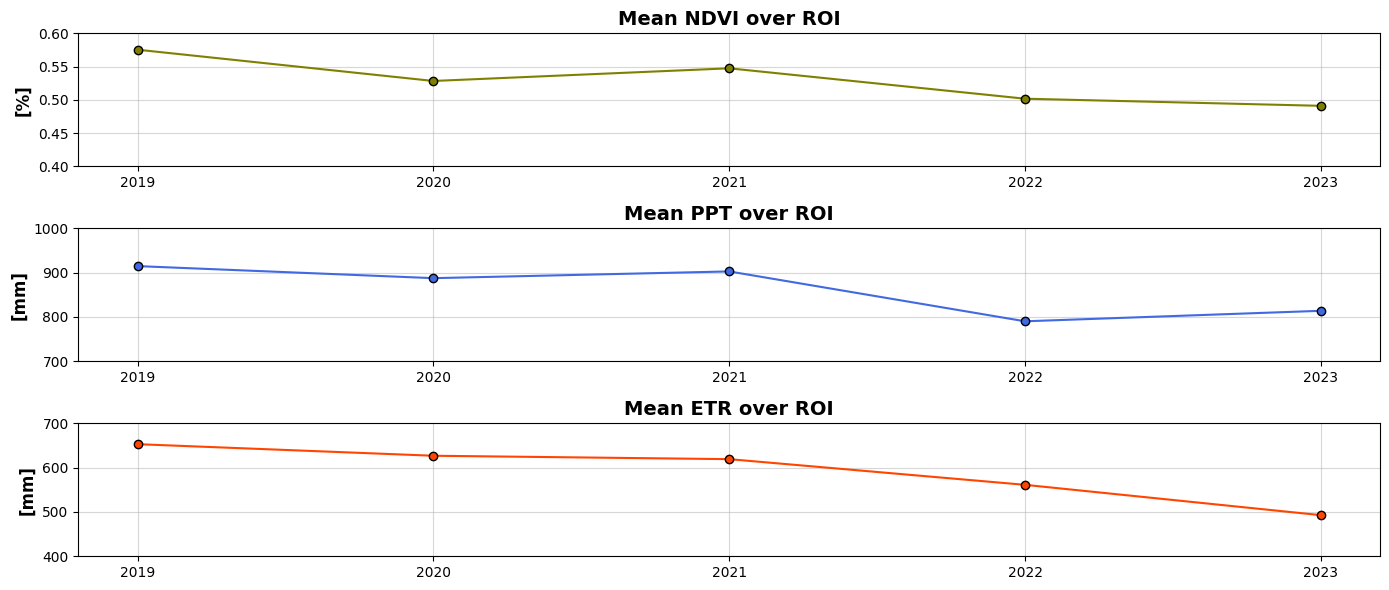

In [70]:
fig, ax = plt.subplots(3, 1, figsize=(14, 6))

# NDVI
ax[0].plot(DF_01["Y"], DF_01["NDVI"], "-o", markeredgecolor="black", color="olive")

ax[0].set_title("Mean NDVI over ROI", fontsize=T_FS, fontweight="bold")

ax[0].set_ylabel("[%]", fontsize=AX_FS, fontweight="bold")

ax[0].set_ylim(0.4, 0.6)

# PPT
ax[1].plot(DF_01["Y"], DF_01["PPT"], "-o", markeredgecolor="black", color="royalblue")

ax[1].set_title("Mean PPT over ROI", fontsize=T_FS, fontweight="bold")

ax[1].set_ylabel("[mm]", fontsize=AX_FS, fontweight="bold")

ax[1].set_ylim(700, 1000)

# ETR
ax[2].plot(DF_01["Y"], DF_01["ETR"], "-o", markeredgecolor="black", color="orangered")

ax[2].set_title("Mean ETR over ROI", fontsize=T_FS, fontweight="bold")

ax[2].set_ylabel("[mm]", fontsize=AX_FS, fontweight="bold")

ax[2].set_ylim(400, 700)

for i in [0, 1, 2]:
    
    ax[i].grid(alpha=.5)
    ax[i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

fig.tight_layout()
# plt.savefig(r"Output/_05.png")
plt.show();